In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# Cell population transitions across fates

In [8]:
# load cell labels
PATH_TO_CELL_LABELS = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/data/clusters.csv"
cluster_labels_df = pd.read_csv(PATH_TO_CELL_LABELS)
cell_labels = cluster_labels_df["Cluster"].tolist()
# get cell labels per window
cell_labels_per_window = get_state_labels_in_window(dictys_dynamic_object, cell_labels)
# get the total counts of cells per state
total_counts_per_state = get_state_total_counts(cell_labels)


In [9]:
def window_labels_to_count_df(window_labels_dict):
    """
    Converts a dictionary of window indices to cell labels into a DataFrame
    with counts of each label per window.
    """
    import pandas as pd
    from collections import Counter
    
    # Get all unique labels
    all_labels = set()
    for labels in window_labels_dict.values():
        all_labels.update(labels)
    
    # Sort labels for consistency
    all_labels = sorted(all_labels)
    
    # Get all window indices
    window_indices = sorted(window_labels_dict.keys())
    
    # Initialize DataFrame with zeros
    count_df = pd.DataFrame(0, index=all_labels, columns=window_indices)
    
    # Fill in the counts for each window
    for window_idx, labels in window_labels_dict.items():
        # Count occurrences of each label in this window
        label_counts = Counter(labels)
        
        # Update the DataFrame
        for label, count in label_counts.items():
            count_df.loc[label, window_idx] = count
    
    return count_df

In [46]:
cell_count_per_window_df = window_labels_to_count_df(cell_labels_per_window)
display(cell_count_per_window_df.head())
#save the cell_count_per_window_df as a csv
cell_count_per_window_df.to_csv(os.path.join(output_folder, 'cell_count_per_window_df.csv'), index=True)

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
ActB-1,1,990,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ActB-2,128,6,0,0,86,78,55,38,34,29,...,0,0,0,0,0,0,0,0,0,0
ActB-3,588,0,0,0,701,753,809,869,892,918,...,0,0,0,0,0,0,0,0,0,0
ActB-4,264,0,0,0,200,157,124,82,66,49,...,0,0,0,0,0,0,0,0,0,0
GC-1,1,0,0,224,0,0,0,0,0,0,...,531,515,468,442,420,375,350,321,294,288


# LF dynamics

In [5]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]

In [6]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 57 genes
Missing 0 genes
Indices: {'LMAN1': 5269, 'TNFAIP8': 10337, 'CEP128': 1733, 'EEA1': 2862, 'FNDC3A': 3516, 'GAB1': 3613, 'CCSER2': 1534, 'CD99': 1598, 'CDK6': 1665, 'SUB1': 9706, 'RUNX2': 8586, 'PPIB': 7507, 'MED23': 5675, 'GLCCI1': 3767, 'CD79A': 1587, 'PAX5': 6943, 'AFF3': 230, 'B2M': 872, 'JCHAIN': 4730, 'MAN1A1': 5488, 'XBP1': 11200, 'TRAM2': 10473, 'ARNTL2': 665, 'BTG2': 1106, 'ELL2': 2979, 'PIKFYVE': 7235, 'SLC25A13': 9042, 'TXNDC5': 10727, 'CD74': 1586, 'MAPK1': 5543, 'PDE4D': 7027, 'TIAM1': 10070, 'RNF213': 8355, 'FNDC3B': 3517, 'SLA': 8982, 'TRAM1': 10472, 'SEL1L3': 8763, 'PRDM1': 7604, 'ARFGAP3': 560, 'TBC1D4': 9887, 'CTSH': 2270, 'HSP90B1': 4304, 'CIITA': 1884, 'IGHM': 4421, 'PIM2': 7239, 'CD52': 1574, 'MZB1': 6199, 'CPEB4': 2131, 'ANKRD28': 429, 'SSR1': 9582, 'TXNDC11': 10722, 'SLAMF7': 8987, 'IQGAP2': 4638, 'UBAC2': 10759, 'DEK': 2479, 'HM13': 4210, 'IRF4': 4652}


# Post bifurcation dynamics of the LF

## Expression dynamics of the genes

In [7]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = lcpm_dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
# save lf_lcpm_dcurve_pb as pd dataframe pickle
#lf_lcpm_dcurve_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_pb.pkl'))

In [8]:
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = lcpm_dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
# save lf_lcpm_dcurve_gc as pickle
#lf_lcpm_dcurve_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_gc.pkl'))

#### Get the curvature of the lcpm expression of all lf genes

In [9]:
# Apply to each gene in lf_lcpm_dcurve_pb
lf_lcpm_curvature_pb = get_curvature_of_expression(lf_lcpm_dcurve_pb, dtime_pb)
lf_lcpm_curvature_gc = get_curvature_of_expression(lf_lcpm_dcurve_gc, dtime_gc)
# save lf_lcpm_curvature_pb as pickle
#lf_lcpm_curvature_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_curvature_pb.pkl'))
# save lf_lcpm_curvature_gc as pickle
#lf_lcpm_curvature_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_curvature_gc.pkl'))

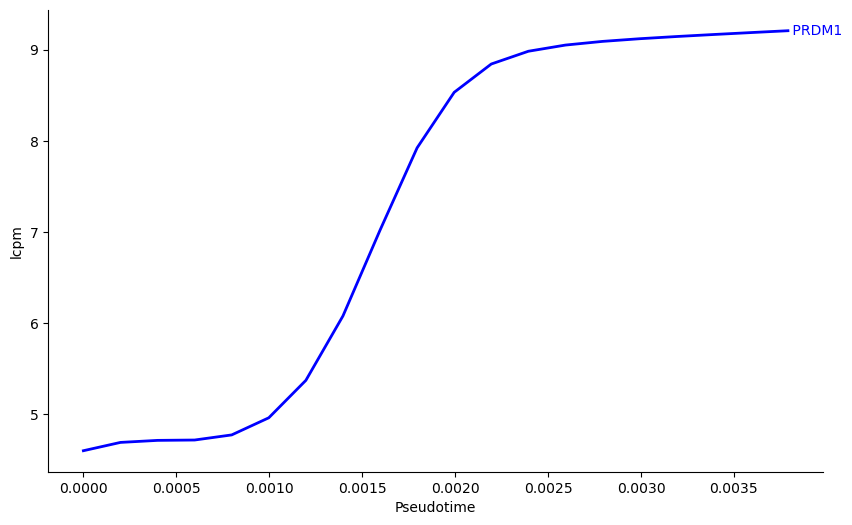

In [10]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['PRDM1']
colors = ['blue']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in lf_lcpm_curvature_gc.index:
        line = plt.plot(dtime_pb, lf_lcpm_dcurve_pb.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_pb.iloc[-1], lf_lcpm_dcurve_pb.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('lcpm')
plt.show()

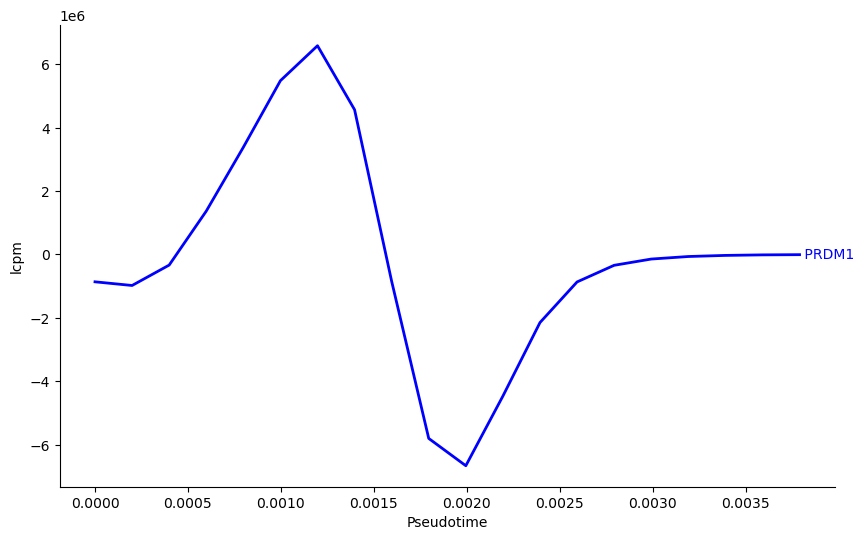

In [11]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['PRDM1']
colors = ['blue']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in lf_lcpm_curvature_gc.index:
        line = plt.plot(dtime_pb, lf_lcpm_curvature_pb.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_pb.iloc[-1], lf_lcpm_curvature_pb.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('lcpm')
plt.show()

# Regulation dynamics of the LF genes


#### Get subnetworks for the dynamic genes in one lineage

In [38]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object,varname='w_in')) #varname can load direct effect or total effect network
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [39]:
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 20)

In [40]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 20)

In [41]:
# # save the dnet and dnetbin as npy 
np.save(os.path.join(output_folder, 'dnet_pb_20pts_total_effect.npy'), dnet)
np.save(os.path.join(output_folder, 'dnetbin_pb_20pts_total_effect.npy'), dnetbin)

In [10]:
#load the dnet and dnetbin
dnet = np.load(os.path.join(output_folder, 'dnet_pb_20pts.npy'))
dnetbin = np.load(os.path.join(output_folder, 'dnetbin_pb_20pts.npy'))

In [11]:
# get indices of the dynamic_pb_genes
lf_genes_indices = get_gene_indices(dictys_dynamic_object, lf_genes)
display(len(lf_genes_indices))  

57

In [12]:
subnetworks_bin = dnetbin[np.ix_(range(dnetbin.shape[0]), lf_genes_indices, range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(551, 57, 20)

#### Filter TFs from the entire list (551)

In [13]:
# Calculate sparsity for each TF (across all genes and timepoints)
TF_density = (subnetworks_bin != 0).mean(axis=(1, 2))
# Keep TFs that are non-zero more than x% of the time
TFs_to_keep = TF_density > 0.01
TFs_to_keep_indices = np.where(TFs_to_keep)[0]

# Get TF names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
TFs_to_keep_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in TFs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in TFs_to_keep_gene_indices]
print(len(kept_tf_names))

219


In [14]:
# Get the subnetworks for the kept TFs
filtered_subnetworks = dnet[np.ix_(TFs_to_keep_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(219, 57, 20)

#### Get beta curves for a lineage


In [15]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in kept_tf_names for target in lf_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve.head())

time_0    time_1        time_2        time_3        time_4  \
TF  Target                                                                 
AHR PIM2   -0.000012 -0.000004 -9.563970e-07 -2.278443e-07 -4.897499e-08   
    GAB1    0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
    SLAMF7  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
    XBP1    0.123697  0.129694  1.320422e-01  1.293663e-01  1.215593e-01   
    AFF3    0.004407  0.005346  5.661372e-03  5.317148e-03  4.520879e-03   

                  time_5        time_6        time_7        time_8  \
TF  Target                                                           
AHR PIM2   -9.584176e-09 -1.690105e-09 -2.584885e-10 -3.220431e-11   
    GAB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    SLAMF7  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    XBP1    1.088066e-01  9.077685e-02  6.739163e-02  4.157534e-02   
    AFF3    3.582351e-03  2.940892e-03  3.599672e-03  7.857343e-03   

                  time_9       time_10       time_11       time_12  \
TF  Target                                                           
AHR PIM2   -3.090887e-12 -2.260402e-13 -1.295480e-14 -6.030090e-16   
    GAB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    SLAMF7  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    XBP1    2.007514e-02  7.482605e-03  2.209565e-03  5.348481e-04   
    AFF3    1.886655e-02  3.765135e-02  6.076654e-02  8.168242e-02   

                 time_13       time_14       time_15       time_16  \
TF  Target                                                           
AHR PIM2   -2.350743e-17 -7.887031e-19 -2.333832e-20 -6.216512e-22   
    GAB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    SLAMF7  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    XBP1    1.093004e-04  1.935891e-05  3.042732e-06  4.328456e-07   
    AFF3    9.455753e-02  9.750673e-02  9.283669e-02  8.483833e-02   

                 time_17       time_18       time_19  
TF  Target                                            
AHR PIM2   -1.514600e-23 -3.417583e-25 -7.214283e-27  
    GAB1    0.000000e+00  0.000000e+00  0.000000e+00  
    SLAMF7  0.000000e+00  0.000000e+00  0.000000e+00  
    XBP1    5.659418e-08  6.882394e-09  7.859777e-10  
    AFF3    7.753082e-02  7.354197e-02  7.395806e-02

In [47]:
# save the lf_beta_dcurve as a pickle
lf_beta_dcurve.to_pickle(os.path.join(output_folder, 'lf_beta_dcurve_pb_total_effect.pkl'))
# load the lf_beta_dcurve from pickle
#lf_beta_dcurve = pd.read_pickle(os.path.join(output_folder, 'lf_beta_dcurve_pb.pkl'))


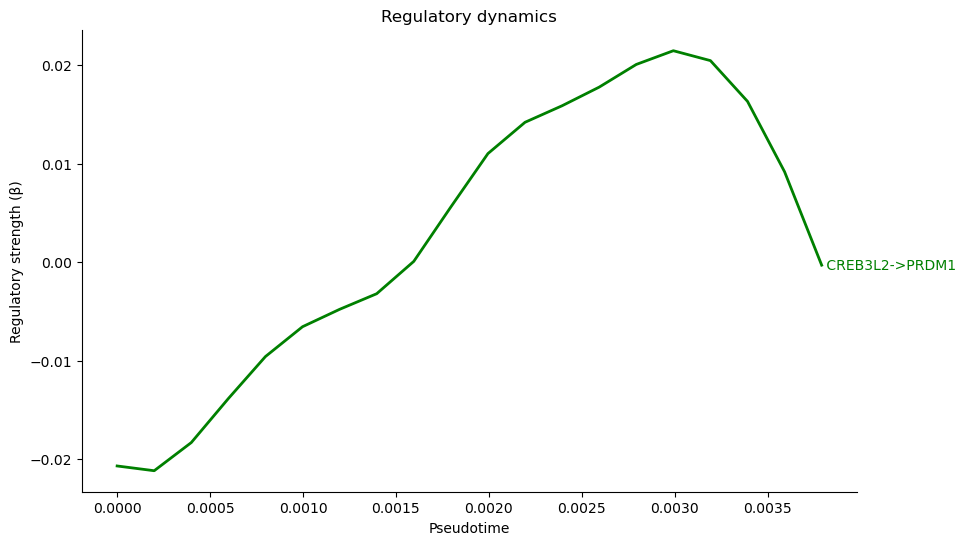

In [48]:
# Plot beta trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Specify TF-target pairs of interest
regulations_of_interest = [('CREB3L2', 'PRDM1')]
colors = ['green']   # Define colors for each regulation

for (tf, target), color in zip(regulations_of_interest, colors):
    # Create multi-index key for the regulation
    idx = pd.MultiIndex.from_tuples([(tf, target)])
    if (tf, target) in lf_beta_dcurve.index:
        line = plt.plot(dtime_pb, lf_beta_dcurve.loc[(tf, target)], 
                       linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_pb.iloc[-1], 
                lf_beta_dcurve.loc[(tf, target)].iloc[-1], 
                f' {tf}->{target}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Regulatory strength (β)')
plt.title('Regulatory dynamics')
plt.show()

#### Get forces for the LF genes

In [16]:
# get the tf_lcpms for the lineage
kept_tfs_lcpm_dcurve = lcpm_dcurve_pb.loc[kept_tf_names]
print(len(kept_tfs_lcpm_dcurve))

219


In [17]:
lf_forces_dcurve = calculate_force_curves(lf_beta_dcurve, kept_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF  Target                                                               
AHR PIM2   -0.016918 -0.010145 -0.005715 -0.003050 -0.001557 -0.000765   
    GAB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SLAMF7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    XBP1    0.950862  0.971146  0.975726  0.962243  0.931353  0.882502   
    AFF3    0.223445  0.243130  0.248487  0.240597  0.222978  0.200392   

              time_6    time_7    time_8    time_9   time_10   time_11  \
TF  Target                                                               
AHR PIM2   -0.000365 -0.000180 -0.000116 -0.000103 -0.000101 -0.000100   
    GAB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SLAMF7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    XBP1    0.810594  0.706841  0.568010  0.410354  0.265204  0.154980   
    AFF3    0.182778  0.198039  0.275498  0.399436  0.534980  0.653704   

             time_12   time_13   time_14   time_15   time_16   time_17  \
TF  Target                                                               
AHR PIM2   -0.000099 -0.000098 -0.000097 -0.000097 -0.000096 -0.000095   
    GAB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SLAMF7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    XBP1    0.083020  0.041276  0.019274  0.008546  0.003631  0.001489   
    AFF3    0.737286  0.778490  0.781255  0.757388  0.721732  0.688385   

             time_18   time_19  
TF  Target                      
AHR PIM2   -0.000094 -0.000094  
    GAB1    0.000000  0.000000  
    SLAMF7  0.000000  0.000000  
    XBP1    0.000596  0.000241  
    AFF3    0.667968  0.665503

(12483, 20)

In [51]:
# save the lf_forces_dcurve_pb as a pickle
lf_forces_dcurve.to_pickle(os.path.join(output_folder, 'lf_forces_dcurve_pb_total_effect.pkl'))
# load lf_forces_dcurve_pb from pickle
#lf_forces_dcurve_pb = pd.read_pickle(os.path.join(output_folder, 'lf_forces_dcurve_pb.pkl'))


In [18]:
lf_force_curves_sorted_by_target = lf_forces_dcurve.sort_index(level=1)
display(lf_force_curves_sorted_by_target.head())
display(lf_force_curves_sorted_by_target.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,time_10,time_11,time_12,time_13,time_14,time_15,time_16,time_17,time_18,time_19
TF,Target,,,,,,,,,,,,,,,,,,,,
AHR,AFF3,0.223445,0.24313,0.248487,0.240597,0.222978,0.200392,0.182778,0.198039,0.275498,0.399436,0.53498,0.653704,0.737286,0.77849,0.781255,0.757388,0.721732,0.688385,0.667968,0.665503
ARID3B,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARID5A,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARNT,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARNTL,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


(12483, 20)

# Picking TFs for local enrichment analysis

In [53]:
def plot_tf_force_histogram_per_target(force_df, target, timepoint_idx=0, n_bins=20, 
                                      fig_size=(10, 6), show_tf_names=True, max_annotations=3,
                                      force_threshold=0.1, use_abs=False):
    """
    Plot histogram of TF force values for a specific target at a specific timepoint
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get column name if timepoint_idx is an integer
    if isinstance(timepoint_idx, int):
        timepoint_name = force_df.columns[timepoint_idx]
    else:
        timepoint_name = timepoint_idx
    
    # Get force values for this target
    target_mask = force_df.index.get_level_values(1) == target
    target_data = force_df[target_mask]
    raw_forces = target_data[timepoint_name].values
    
    # Use absolute values for histogram if requested
    if use_abs:
        forces = np.abs(raw_forces)
    else:
        forces = raw_forces
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Generate histogram
    counts, bins, patches = ax.hist(forces, bins=n_bins, alpha=0.7, color='skyblue', 
                                   edgecolor='black')
    
    # Add bin annotations (count of TFs in each bin)
    for i in range(len(patches)):
        # Get x position of the bin
        x = (bins[i] + bins[i+1]) / 2
        # Get y position (count)
        y = counts[i]
        # Add text if count > 0
        if y > 0:
            ax.text(x, y + (max(counts) * 0.02) if max(counts) > 0 else 0.5, 
                   f'{int(y)}', ha='center', va='bottom', fontsize=8)
    
    # Get TF names for annotations
    tfs = target_data.index.get_level_values(0).values
    # Annotate strong TFs if requested
    if show_tf_names:
        # Create lists to store strong positive and negative TFs
        strong_pos_tfs = []
        strong_neg_tfs = []
        
        # Find TFs with force above threshold
        for tf, force in zip(tfs, raw_forces):  # Use raw forces for directional information
            abs_force = abs(force)
            if abs_force > force_threshold:
                if force > 0:
                    strong_pos_tfs.append((tf, force))
                else:
                    strong_neg_tfs.append((tf, force))
        
        # Sort by absolute force
        strong_pos_tfs.sort(key=lambda x: x[1], reverse=True)
        strong_neg_tfs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Limit to max_annotations for each category
        strong_pos_tfs = strong_pos_tfs[:max_annotations]
        strong_neg_tfs = strong_neg_tfs[:max_annotations]
        
        # Add text annotations within the plot area
        y_pos = 0.92  # Position relative to axes (0-1 range)
        if strong_pos_tfs:
            pos_text = "Top positive TFs: " + ", ".join([f"{tf} ({force:.2f})" for tf, force in strong_pos_tfs])
            ax.text(0.5, y_pos, pos_text, ha='center', va='top', 
                   fontsize=9, color='green', transform=ax.transAxes, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
            y_pos -= 0.07  # Move down for next annotation
        
        if strong_neg_tfs:
            neg_text = "Top negative TFs: " + ", ".join([f"{tf} ({force:.2f})" for tf, force in strong_neg_tfs])
            ax.text(0.5, y_pos, neg_text, ha='center', va='top', 
                   fontsize=9, color='red', transform=ax.transAxes, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
    
    # Set plot labels and title
    if use_abs:
        ax.set_xlabel('Absolute Force Value')
        ax.set_title(f'Distribution of Absolute TF Forces for {target} at Timepoint {timepoint_name}')
    else:
        ax.set_xlabel('Force Value')
        ax.set_title(f'Distribution of TF Forces for {target} at Timepoint {timepoint_name}')
    
    ax.set_ylabel('Count of TFs')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid
    ax.grid(axis='y', alpha=0.3)
    
    return fig, ax

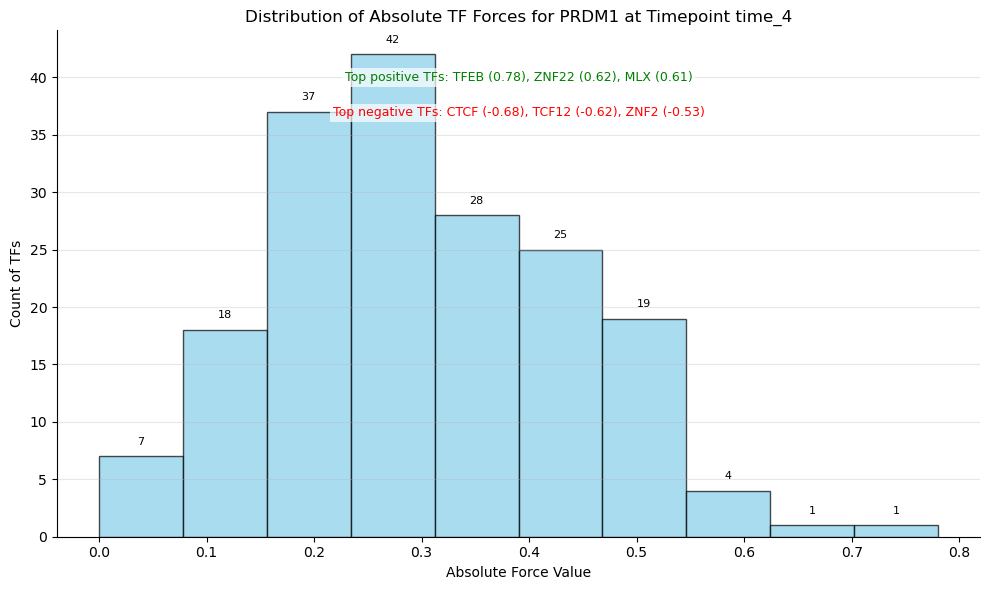

In [54]:
# Example usage:
# 1. For a single target with absolute force values
timepoint_idx = 4
target_of_interest = "PRDM1"  # Replace with your target of interest

fig, ax = plot_tf_force_histogram_per_target(
    force_df=lf_force_curves_sorted_by_target,
    target=target_of_interest,
    timepoint_idx=timepoint_idx,
    n_bins=10,
    show_tf_names=True,
    force_threshold=0.1,
    use_abs=True  # Use absolute force values
)
plt.tight_layout()
plt.show()


In [19]:
def find_top_percentile_tfs_across_time(force_df, percentile=95, time_window=None, use_abs=True):
    """
    Find TFs that are in the top percentile of force values across consecutive timepoints.
    """
    import numpy as np
    from collections import defaultdict
    
    # Get the timepoints to analyze
    if time_window is None:
        timepoints = force_df.columns
    else:
        start, end = time_window
        timepoints = force_df.columns[start:end]
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Dictionary to store TF persistence per target
    target_tf_persistence = {}
    
    # Process each target separately
    for target in targets:
        # Dictionary to track consecutive appearances for this target
        tf_consecutive_counts = defaultdict(int)
        
        # Previous timepoint's top TFs
        prev_top_tfs = set()
        
        # Get all TFs for this target
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Skip targets with no data
        if len(target_data) == 0:
            continue
            
        # Iterate through timepoints
        for i, timepoint in enumerate(timepoints):
            # Get force values for this timepoint
            forces = target_data[timepoint].values
            
            # Use absolute values if requested
            if use_abs:
                forces = np.abs(forces)
            
            # Calculate the percentile threshold
            threshold = np.percentile(forces, percentile)
            
            # Find TFs above the threshold
            tf_indices = np.where(forces >= threshold)[0]
            
            # Get TF names
            current_top_tfs = set(target_data.index.get_level_values(0)[tf_indices])
            
            # For the first timepoint, just set previous TFs
            if i == 0:
                prev_top_tfs = current_top_tfs
                continue
            
            # Find TFs that appear in both current and previous timepoints
            consecutive_tfs = current_top_tfs.intersection(prev_top_tfs)
            
            # Increment counts for consecutive TFs
            for tf in consecutive_tfs:
                tf_consecutive_counts[tf] += 1
            
            # Update previous timepoint's TFs
            prev_top_tfs = current_top_tfs
        
        # Store results for this target
        target_tf_persistence[target] = dict(tf_consecutive_counts)
    
    return target_tf_persistence

def get_target_specific_regulators(force_df, percentile=95, time_window=None, 
                                use_abs=True, min_consecutive=1, target_list=None):
    """
    Find TFs that consistently appear in the top percentile of force values for specific targets.
    """
    # Get TF persistence data for all targets
    target_tf_persistence = find_top_percentile_tfs_across_time(
        force_df=force_df,
        percentile=percentile,
        time_window=time_window,
        use_abs=use_abs
    )
    
    # Filter by minimum consecutive appearances and targets of interest
    filtered_persistence = {}
    
    for target, tf_dict in target_tf_persistence.items():
        # Skip if not in target list (when specified)
        if target_list is not None and target not in target_list:
            continue
            
        # Filter TFs by minimum consecutive appearances
        filtered_tfs = {tf: count for tf, count in tf_dict.items() if count >= min_consecutive}
        
        # Only add if there are any TFs left after filtering
        if filtered_tfs:
            filtered_persistence[target] = filtered_tfs
    
    return filtered_persistence

def visualize_top_regulators_per_target(target_regulators, top_n=10, figsize=(15, 10), n_cols=2):
    """
    Visualize top regulating TFs for multiple targets.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    
    # Get number of targets
    n_targets = len(target_regulators)
    
    # Calculate number of rows needed
    n_rows = math.ceil(n_targets / n_cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Create bar chart for each target
    for i, (target, tf_persistence) in enumerate(target_regulators.items()):
        if i < len(axes):
            ax = axes[i]
            
            # Sort TFs by persistence count
            sorted_tfs = sorted(tf_persistence.items(), key=lambda x: x[1], reverse=True)[:top_n]
            
            if not sorted_tfs:
                ax.text(0.5, 0.5, f"No persistent TFs for {target}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
                continue
                
            # Get TF names and counts
            tf_names = [tf for tf, _ in sorted_tfs]
            tf_counts = [count for _, count in sorted_tfs]
            
            # Plot horizontal bar chart for better readability of TF names
            bars = ax.barh(tf_names, tf_counts, color='skyblue', edgecolor='black')
            
            # Add count labels
            for bar, count in zip(bars, tf_counts):
                ax.text(count + 0.1, bar.get_y() + bar.get_height()/2, 
                       str(count), va='center', fontsize=9)
            
            # Set title and labels
            ax.set_title(f"{target}")
            ax.set_xlabel("Consecutive Appearances")
            
            # Remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
    # Hide unused subplots
    for i in range(n_targets, len(axes)):
        axes[i].axis('off')
    
    # Add overall title
    plt.suptitle("Persistent Top Regulating TFs by Target", fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

In [158]:
# 1. Find target-specific regulators
percentile = 90 # need to tune (85 for total effect, 90 for direct effect)
time_window = 15,19 # create 4 blocks of 5 timepoints each
use_abs = True  # Use absolute force values
min_consecutive = 2  # TF must appear in consecutive timepoints at least this many times

# Choose specific targets or use None for all targets in LF
targets_of_interest = None

target_regulators = get_target_specific_regulators(
    force_df=lf_force_curves_sorted_by_target,
    percentile=percentile,
    time_window=time_window,
    use_abs=use_abs,
    min_consecutive=min_consecutive,
    target_list=targets_of_interest
)
# save as a pickle
#pickle.dump(target_regulators, open(os.path.join(output_folder, 'target_regulators_3rd_block_pb_total_effect.pkl'), 'wb'))


In [159]:
#load the target_regulators
#target_regulators = pickle.load(open(os.path.join(output_folder, 'target_regulators_2nd_block_pb_total_effect.pkl'), 'rb'))
display(target_regulators)

{'AFF3': {np.str_('MZF1'): 3,
  np.str_('IKZF1'): 3,
  np.str_('AHR'): 3,
  np.str_('SOX4'): 3,
  np.str_('TCF12'): 3,
  np.str_('MEF2C'): 3,
  np.str_('ZNF37A'): 3,
  np.str_('ZNF736'): 2,
  np.str_('CTCF'): 3,
  np.str_('ELF1'): 2,
  np.str_('REL'): 3,
  np.str_('TCFL5'): 3,
  np.str_('NFATC3'): 3,
  np.str_('GABPA'): 3,
  np.str_('NRF1'): 3,
  np.str_('RUNX3'): 3,
  np.str_('ELK3'): 3,
  np.str_('ZNF846'): 3,
  np.str_('ZNF566'): 2,
  np.str_('ZNF2'): 2},
 'ANKRD28': {np.str_('NFYB'): 3,
  np.str_('KLF13'): 2,
  np.str_('RUNX1'): 3,
  np.str_('MZF1'): 3,
  np.str_('NFYC'): 2,
  np.str_('TCF4'): 3,
  np.str_('TCF12'): 3,
  np.str_('ZNF730'): 3,
  np.str_('MEF2C'): 2,
  np.str_('MAZ'): 3,
  np.str_('ZNF736'): 3,
  np.str_('CTCF'): 3,
  np.str_('MECP2'): 3,
  np.str_('ZNF22'): 3,
  np.str_('ZNF571'): 3,
  np.str_('TCFL5'): 2,
  np.str_('IKZF3'): 3,
  np.str_('ZNF519'): 3,
  np.str_('NRF1'): 3,
  np.str_('RUNX3'): 3,
  np.str_('LIN54'): 2},
 'ARFGAP3': {np.str_('ELK4'): 3,
  np.str_('ZN

In [25]:
# fig, ax, force_values = plot_force_heatmap(
#     force_df=lf_forces_dcurve,
#     dtime=dtime_pb,
#     regulations=[('IRF4','PRDM1'),('PRDM1','IRF4'),('PRDM1','CIITA')],
#     figsize=(12, 2),
#     cmap='RdYlGn'
# )

## Get the local enrichment  for the picked TFs

In [160]:
# get the regulators for all the targets
all_lf_targets = list(target_regulators.keys())
strong_tfs = set()
for target in all_lf_targets:
    strong_tfs.update(list(target_regulators[target].keys()))

display(len(strong_tfs))

197

In [161]:
# get the total down-stream targets of the filtered TFs
strong_tfs_indices, _, _ = get_tf_indices(dictys_dynamic_object, strong_tfs)
print(len(strong_tfs_indices))

197


In [162]:
# Get the subnetworks for the kept TFs
strong_tfs_total_effect_subnetwork_of_lf = dnet[np.ix_(strong_tfs_indices, range(dnet.shape[1]), range(dnet.shape[2]))]
display(strong_tfs_total_effect_subnetwork_of_lf.shape)

(197, 11907, 20)

#### Filter the subnetwork for active target genes (from 11907) {the total effect grn is not sparse}

In [163]:
# Calculate sparsity for each target (across all TFs and timepoints)
target_density = (strong_tfs_total_effect_subnetwork_of_lf != 0).mean(axis=(0, 2))

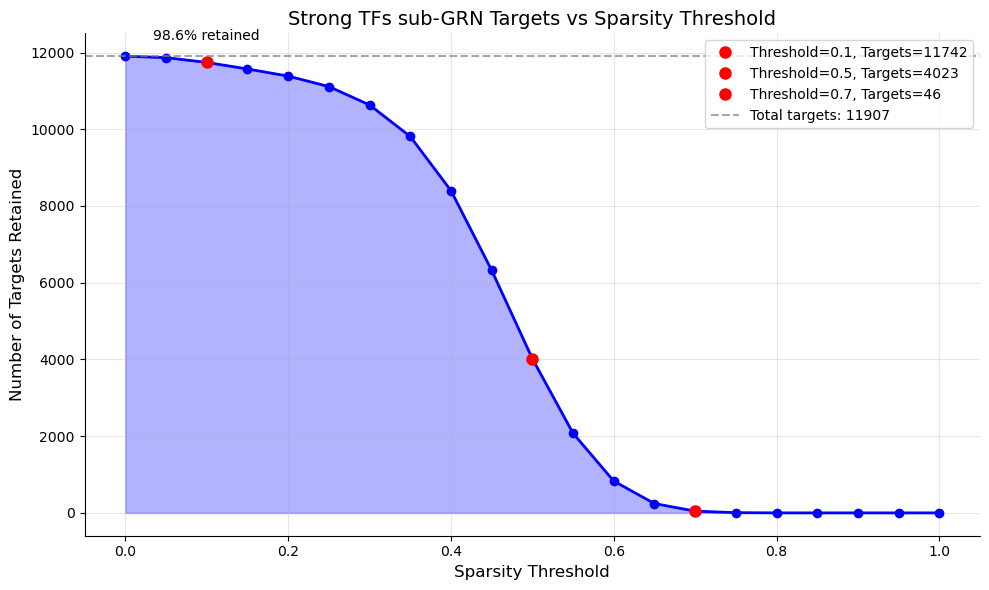

In [164]:
# Calculate number of targets at different sparsity thresholds
sparsity_thresholds = np.arange(0, 1.05, 0.05)  # From 0 to 1 in steps of 0.05
num_targets = []

for threshold in sparsity_thresholds:
    targets_to_keep = target_density > threshold
    num_targets.append(np.sum(targets_to_keep))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot line
ax.plot(sparsity_thresholds, num_targets, 'o-', linewidth=2, color='blue')

# Add markers at key thresholds
key_thresholds = [0.1, 0.5, 0.7]
for threshold in key_thresholds:
    idx = np.abs(sparsity_thresholds - threshold).argmin()
    ax.plot(sparsity_thresholds[idx], num_targets[idx], 'o', markersize=8, 
            color='red', label=f'Threshold={threshold}, Targets={num_targets[idx]}')

# Fill area under curve
ax.fill_between(sparsity_thresholds, num_targets, alpha=0.3, color='blue')

# Customize plot
ax.set_xlabel('Sparsity Threshold', fontsize=12)
ax.set_ylabel('Number of Targets Retained', fontsize=12)
ax.set_title('Strong TFs sub-GRN Targets vs Sparsity Threshold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a horizontal line showing total possible targets
ax.axhline(y=11907, color='gray', linestyle='--', alpha=0.7, 
           label=f'Total targets: 11907')

# Add a text annotation showing percentage retained at 0.1 threshold
percent_retained = (num_targets[np.abs(sparsity_thresholds - 0.1).argmin()] / 11907) * 100
ax.text(0.1, num_targets[np.abs(sparsity_thresholds - 0.1).argmin()] + 500, 
        f'{percent_retained:.1f}% retained', 
        ha='center', va='bottom', fontsize=10)

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

In [165]:
# Keep targets that are non-zero more than x% of the time
targets_to_keep = target_density > 0.5
targets_to_keep_indices = np.where(targets_to_keep)[0]
display(len(targets_to_keep_indices))

4023

In [166]:
# Get the subnetworks for the kept TFs
strong_tfs_total_effect_subnetwork_of_lf = dnet[np.ix_(strong_tfs_indices, targets_to_keep_indices, range(dnet.shape[2]))]
display(strong_tfs_total_effect_subnetwork_of_lf.shape)

(197, 4023, 20)

In [167]:
# Get target names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
kept_target_names = [index_to_gene[idx] for idx in targets_to_keep_indices]
print(len(kept_target_names))

4023


In [168]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in strong_tfs for target in kept_target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = strong_tfs_total_effect_subnetwork_of_lf.shape
reshaped_data = strong_tfs_total_effect_subnetwork_of_lf.reshape(-1, n_times)

# Create DataFrame with multi-index
strong_tfs_total_effect_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(strong_tfs_total_effect_beta_dcurve.head())
display(strong_tfs_total_effect_beta_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF   Target                                                               
TFEC AAGAB  -0.006796 -0.006704 -0.006433 -0.006059 -0.005603 -0.005022   
     AAK1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     AAMP    0.002394  0.001985  0.001437  0.000923  0.000534  0.000282   
     AARS2  -0.000196 -0.000104 -0.000048 -0.000020 -0.000007 -0.000002   
     AATF   -0.004266 -0.006480 -0.008778 -0.010841 -0.012538 -0.013843   

                   time_6        time_7        time_8        time_9  \
TF   Target                                                           
TFEC AAGAB  -4.229079e-03 -3.169448e-03 -1.964201e-03 -9.455869e-04   
     AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
     AAMP    1.338648e-04  5.516318e-05  1.851686e-05  4.788193e-06   
     AARS2  -7.412188e-07 -1.949458e-07 -4.176632e-08 -6.893423e-09   
     AATF   -1.455436e-02 -1.407031e-02 -1.171206e-02 -7.875404e-03   

                  time_10       time_11       time_12       time_13  \
TF   Target                                                           
TFEC AAGAB  -3.483818e-04 -1.008045e-04 -2.371008e-05 -4.671459e-06   
     AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
     AAMP    9.434070e-07  1.456662e-07  1.826652e-08  1.918360e-09   
     AARS2  -8.669158e-10 -8.544003e-11 -6.839016e-12 -4.584732e-13   
     AATF   -4.187892e-03 -1.793314e-03 -6.355527e-04 -1.910389e-04   

                  time_14       time_15       time_16       time_17  \
TF   Target                                                           
TFEC AAGAB  -7.919722e-07 -1.183670e-07 -1.591586e-08 -1.956240e-09   
     AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
     AAMP    1.733887e-10  1.382127e-11  9.917111e-13  6.508558e-14   
     AARS2  -2.645218e-14 -1.346035e-15 -6.165557e-17 -2.583224e-18   
     AATF   -4.983279e-05 -1.152605e-05 -2.408007e-06 -4.611707e-07   

                  time_18       time_19  
TF   Target                              
TFEC AAGAB  -2.225207e-10 -2.366066e-11  
     AAK1    0.000000e+00  0.000000e+00  
     AAMP    3.955878e-15  2.249273e-16  
     AARS2  -1.002356e-19 -3.638601e-21  
     AATF   -8.191127e-08 -1.362280e-08

(792531, 20)

In [169]:
# get the tf_lcpms for the lineage
strong_tfs_lcpm_dcurve = lcpm_dcurve_pb.loc[list(strong_tfs)]
print(len(strong_tfs_lcpm_dcurve))

197


In [170]:
strong_tfs_all_forces_dcurve = calculate_force_curves(strong_tfs_total_effect_beta_dcurve, strong_tfs_lcpm_dcurve)
strong_tfs_all_forces_dcurve = strong_tfs_all_forces_dcurve.sort_index(level=1)
display(strong_tfs_all_forces_dcurve.head())
display(strong_tfs_all_forces_dcurve.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,time_10,time_11,time_12,time_13,time_14,time_15,time_16,time_17,time_18,time_19
TF,Target,,,,,,,,,,,,,,,,,,,,
AHR,AAGAB,0.158653,0.199502,0.237017,0.267026,0.287585,0.297323,0.293634,0.272255,0.230624,0.174423,0.117348,0.071051,0.039277,0.020081,0.009614,0.004359,0.001890,0.000791,0.000327,0.000150
ARID3B,AAGAB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARID5A,AAGAB,0.017586,0.010242,0.005610,0.002913,0.001446,0.000691,0.000322,0.000160,0.000109,0.000099,0.000097,0.000096,0.000095,0.000094,0.000093,0.000092,0.000092,0.000091,0.000090,0.000090
ARNT,AAGAB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARNTL,AAGAB,0.200634,0.188808,0.171696,0.150894,0.129492,0.110620,0.095958,0.084864,0.077173,0.081430,0.108241,0.151552,0.200666,0.247627,0.286737,0.314527,0.329608,0.332228,0.323803,0.306505


(792531, 20)

In [110]:
def process_target_chunk_for_parallel(targets_chunk_args):
    """
    Process a chunk of targets to find TFs in the top percentile across consecutive timepoints
    """
    from collections import defaultdict
    import numpy as np
    
    targets_chunk, force_df, time_window, percentile, use_abs = targets_chunk_args
    
    # Get the timepoints to analyze
    if time_window is None:
        timepoints = force_df.columns
    else:
        start, end = time_window
        timepoints = force_df.columns[start:end]
    
    # Dictionary to store results for this chunk
    chunk_results = {}
    
    # Process each target in the chunk
    for target in targets_chunk:
        # Dictionary to track consecutive appearances for this target
        tf_consecutive_counts = defaultdict(int)
        
        # Previous timepoint's top TFs
        prev_top_tfs = set()
        
        # Get all TFs for this target
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Skip targets with no data
        if len(target_data) == 0:
            continue
            
        # Iterate through timepoints
        for i, timepoint in enumerate(timepoints):
            # Get force values for this timepoint
            forces = target_data[timepoint].values
            
            # Use absolute values if requested
            if use_abs:
                forces = np.abs(forces)
            
            # Calculate the percentile threshold
            threshold = np.percentile(forces, percentile)
            
            # Find TFs above the threshold
            tf_indices = np.where(forces >= threshold)[0]
            
            # Get TF names
            current_top_tfs = set(target_data.index.get_level_values(0)[tf_indices])
            
            # For the first timepoint, just set previous TFs
            if i == 0:
                prev_top_tfs = current_top_tfs
                continue
            
            # Find TFs that appear in both current and previous timepoints
            consecutive_tfs = current_top_tfs.intersection(prev_top_tfs)
            
            # Increment counts for consecutive TFs
            for tf in consecutive_tfs:
                tf_consecutive_counts[tf] += 1
            
            # Update previous timepoint's TFs
            prev_top_tfs = current_top_tfs
        
        # Store results for this target
        if tf_consecutive_counts:
            chunk_results[target] = dict(tf_consecutive_counts)
    
    return chunk_results

def find_top_percentile_tfs_across_time_parallel(force_df, percentile=95, time_window=None, 
                                                use_abs=True, n_jobs=None, chunk_size=100):
    """
    Find TFs that are in the top percentile of force values across consecutive timepoints using parallel processing.
    """
    import multiprocessing as mp
    from tqdm import tqdm
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Set number of processes
    if n_jobs is None:
        n_jobs = mp.cpu_count()
    
    # Split targets into chunks
    target_chunks = [targets[i:i + chunk_size] for i in range(0, len(targets), chunk_size)]
    print(f"Processing {len(targets)} targets in {len(target_chunks)} chunks using {n_jobs} CPU cores...")
    
    # Create arguments list
    args_list = [(chunk, force_df, time_window, percentile, use_abs) for chunk in target_chunks]
    
    # Process in parallel
    with mp.Pool(processes=n_jobs, maxtasksperchild=10) as pool:
        results = list(tqdm(
            pool.imap(process_target_chunk_for_parallel, args_list),
            total=len(target_chunks),
            desc="Finding top percentile TFs"
        ))
    
    # Combine results from all chunks
    combined_results = {}
    for chunk_result in results:
        combined_results.update(chunk_result)
    
    print(f"Found TF persistence data for {len(combined_results)} targets")
    return combined_results

def get_target_specific_regulators_parallel(force_df, percentile=95, time_window=None, 
                                use_abs=True, min_consecutive=1, target_list=None, n_jobs=None, chunk_size=100):
    """
    Find TFs that consistently appear in the top percentile of force values for specific targets.
    Parallel implementation of get_target_specific_regulators.
    """
    # Get TF persistence data for all targets
    target_tf_persistence = find_top_percentile_tfs_across_time_parallel(
        force_df=force_df,
        percentile=percentile,
        time_window=time_window,
        use_abs=use_abs,
        n_jobs=n_jobs,
        chunk_size=chunk_size
    )
    
    # Filter by minimum consecutive appearances and targets of interest
    filtered_persistence = {}
    
    for target, tf_dict in target_tf_persistence.items():
        # Skip if not in target list (when specified)
        if target_list is not None and target not in target_list:
            continue
            
        # Filter TFs by minimum consecutive appearances
        filtered_tfs = {tf: count for tf, count in tf_dict.items() if count >= min_consecutive}
        
        # Only add if there are any TFs left after filtering
        if filtered_tfs:
            filtered_persistence[target] = filtered_tfs
    
    return filtered_persistence

In [171]:
strong_links_subGRN_filtered_tfs = get_target_specific_regulators_parallel(
    force_df=strong_tfs_all_forces_dcurve,
    percentile=90,
    time_window=(15,19),
    use_abs=True,
    min_consecutive=2,
    target_list=None,
    n_jobs=64,
    chunk_size=100
)

Processing 4023 targets in 41 chunks using 64 CPU cores...


Finding top percentile TFs: 100%|██████████| 41/41 [00:10<00:00,  3.76it/s]


Found TF persistence data for 4023 targets


In [69]:
# save the strong_links_subGRN_filtered_tfs as a pickle
#pickle.dump(strong_links_subGRN_filtered_tfs, open(os.path.join(output_folder, 'strong_links_subGRN_filtered_tfs_0_4_90_pb.pkl'), 'wb'))


In [172]:
total_tf_target_pairs = 0
for target, tf_dict in strong_links_subGRN_filtered_tfs.items():
    total_tf_target_pairs += len(tf_dict)
print(f"Total number of TF-target pairs: {total_tf_target_pairs}")

Total number of TF-target pairs: 71994


#### Get enrichment of filtered TFs related to the LF

In [113]:
def convert_target_tf_to_tf_target(target_tf_dict):
    # Initialize the TF -> targets dictionary
    tf_to_targets = {}
    
    # Iterate through targets and their TF dictionaries
    for target, tf_dict in target_tf_dict.items():
        # Iterate through TFs for this target
        for tf in tf_dict.keys():
            # Initialize the list for this TF if not already present
            if tf not in tf_to_targets:
                tf_to_targets[tf] = []
            
            # Add the target to this TF's list
            tf_to_targets[tf].append(target)
    
    return tf_to_targets

In [173]:
# Convert the target-to-TF dictionary to TF-to-targets dictionary
tfs_to_targets_in_lf = convert_target_tf_to_tf_target(target_regulators)
tfs_to_all_targets = convert_target_tf_to_tf_target(strong_links_subGRN_filtered_tfs)
total_tf_target_pairs = 0
for tf, targets in tfs_to_all_targets.items():
    total_tf_target_pairs += len(targets)
print(f"Total number of TF-target pairs: {total_tf_target_pairs}")


Total number of TF-target pairs: 71994


In [78]:
def calculate_dynamic_tf_enrichment(tf_lf_targets_dict, tf_all_targets_dict, condition="GC", total_genes=None, total_lf_genes=None):
    """
    Calculate enrichment scores for transcription factors regulating latent factor genes
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import hypergeom
    import math
    
    # Get the total number of LF genes
    if total_lf_genes is None:
        # Calculate from dictionary if not provided
        all_lf_genes = set()
        for targets in tf_lf_targets_dict.values():
            all_lf_genes.update(targets)
        N = len(all_lf_genes)  # Total LF genes
    else:
        N = total_lf_genes  # Use provided value
    
    # If total_genes is not provided, estimate from the all_targets dictionary
    if total_genes is None:
        all_possible_targets = set()
        for targets in tf_all_targets_dict.values():
            all_possible_targets.update(targets)
        M = len(all_possible_targets)  # Total genes in the universe
    else:
        M = total_genes
    
    # Calculate enrichment for each TF
    results = []
    
    for tf in tf_lf_targets_dict.keys():
        if tf in tf_all_targets_dict:
            # Get unique targets for this TF
            lf_targets = set(tf_lf_targets_dict[tf])
            all_targets = set(tf_all_targets_dict[tf])
            
            # Calculate parameters for hypergeometric test
            n = len(all_targets)  # Number of total downstream targets
            X = len(lf_targets)   # Number of LF targets
            
            # Skip if there are no targets or all targets
            if n == 0 or n == M:
                continue
                
            # Calculate enrichment
            try:
                p_value = 1 - hypergeom.cdf(X-1, M, n, N)
                score = math.log2((X/n)/(N/M)) if X > 0 else float('-inf')
                
                # Format the results
                lf_genes = ", ".join(sorted(lf_targets))
                downstream_genes = ", ".join(sorted(all_targets))
                
                results.append({
                    'TF': f"({tf},)",
                    'Condition': f"({condition},)",
                    'Score': score,
                    'p_value': p_value,
                    'lf_targets': lf_genes,
                    'dwnstrm': downstream_genes
                })
            except Exception as e:
                print(f"Error calculating enrichment for {tf}: {e}")
                print(f"M={M}, n={n}, N={N}, X={X}")
    # Create DataFrame
    enrichment_df = pd.DataFrame(results)
    # Sort by p-value (ascending) and Score (descending)
    if not enrichment_df.empty:
        enrichment_df = enrichment_df.sort_values(by=['p_value', 'Score'], 
                                                 ascending=[True, False])
    return enrichment_df


In [174]:
enrichment_tf = calculate_dynamic_tf_enrichment(
    tfs_to_targets_in_lf,                  # Dictionary with TFs -> LF targets
    tfs_to_all_targets,    # Dictionary with TFs -> all downstream targets
    condition="PB",
    total_genes=len(dictys_dynamic_object.ndict),  # Total number of genes in the analysis
    total_lf_genes=len(lf_genes)     # Total number of LF genes
)
p_value_cutoff = 0.01
significant_tfs = enrichment_tf[enrichment_tf['p_value'] < p_value_cutoff]
# sort by score
significant_tfs = significant_tfs.sort_values(by='Score', ascending=False)
# Save to CSV
#enrichment_tf.to_csv(os.path.join(output_folder, 'LF_enriched_dynamic_TFs_PB.csv'), index=False)

In [175]:
display(significant_tfs.head(20))

,TF,Condition,Score,p_value,lf_targets,dwnstrm
119,"(ZNF354C,)","(PB,)",5.121670,1.440992e-03,"CEP128, MAPK1","CEP128, CYBB, DYNLT3, FAM20B, IGLV3-25, IGLV4-..."
98,"(ZNF528,)","(PB,)",4.899277,1.974644e-03,"CD79A, PAX5","ADK, ARHGEF1, CGGBP1, CXCR4, DIPK2A, INTS13, I..."
172,"(TCF7L2,)","(PB,)",4.121670,5.808072e-03,"IRF4, MAPK1","AKAP6, ARHGAP11A, BASP1-AS1, CYBB, DYNLT3, FAM..."
162,"(ZNF98,)","(PB,)",3.951745,1.248898e-04,"HSP90B1, MZB1, SEL1L3, UBAC2","ACVR1, ADD3, ANKRD6, ARID5B, ATP1A1, BTN3A2, C..."
137,"(ZNF740,)","(PB,)",3.848651,8.414016e-03,"CTSH, TXNDC11","ANKH, BZW2, CDC42-IT1, CDK5RAP2, CHEK2, CNTRL,..."
161,"(MNT,)","(PB,)",3.823989,1.765678e-04,"HSP90B1, PRDM1, SSR1, TRAM1","ANP32B, ARL4A, ARPC5, ARSK, ATXN3, C12orf57, C..."
97,"(ZNF480,)","(PB,)",3.421230,5.172992e-04,"CD79A, GLCCI1, HM13, MED23","ABTB2, ACADM, ACSM1, ADH5, AGBL1, ANK3, APOBEC..."
7,"(ZNF736,)","(PB,)",3.384704,5.695137e-04,"AFF3, ANKRD28, ELL2, IQGAP2","AARS2, AIFM1, AKAP12, ALG14, ANKRD28, ANXA6, A..."
134,"(TFEB,)","(PB,)",3.247201,7.643810e-08,"CPEB4, ELL2, HSP90B1, PRDM1, RNF213, SLA, SSR1...","ABHD17B, ABRAXAS1, ACAA2, ACOT13, ADA, AGPS, A..."
131,"(CIC,)","(PB,)",3.133743,2.534107e-04,"CIITA, ELL2, IQGAP2, UBAC2, XBP1","ABCA1, ABCC4, ACTR8, ADAMTS6, ALG14, ANAPC4, A..."


#### Analysis of the enrichment_tf

In [37]:
# load the enrichment_tfs from csv
enrichment_tf_gc = pd.read_csv(os.path.join(output_folder, 'LF_enriched_dynamic_TFs_GC.csv'))
enrichment_tf_pb = pd.read_csv(os.path.join(output_folder, 'LF_enriched_dynamic_TFs_PB.csv'))

In [45]:
p_value_cutoff = 0.05
significant_tfs_gc = enrichment_tf_gc[enrichment_tf_gc['p_value'] < p_value_cutoff]
significant_tfs_pb = enrichment_tf_pb[enrichment_tf_pb['p_value'] < p_value_cutoff]
print(len(significant_tfs_gc))
print(len(significant_tfs_pb))

18
24


In [54]:
common_tfs = set(significant_tfs_gc['TF']) & set(significant_tfs_pb['TF'])
print(len(common_tfs))
# make data by querying the common_tfs from the enrichment_tf_gc and enrichment_tf_pb
# Create a DataFrame with common TFs and their targets from both conditions
common_tf_data = []
for tf in common_tfs:
    # Get data for this TF in GC
    gc_row = significant_tfs_gc[significant_tfs_gc['TF'] == tf].iloc[0]
    
    # Get data for this TF in PB
    pb_row = significant_tfs_pb[significant_tfs_pb['TF'] == tf].iloc[0]
    
    # Convert target strings to sets for comparison
    gc_targets = set(target.strip() for target in gc_row['lf_targets'].split(','))
    pb_targets = set(target.strip() for target in pb_row['lf_targets'].split(','))
    
    # Find common targets
    common_targets = gc_targets.intersection(pb_targets)
    
    common_tf_data.append({
        'TF': tf,
        'GC_Score': gc_row['Score'],
        'PB_Score': pb_row['Score'],
        'GC_pvalue': gc_row['p_value'],
        'PB_pvalue': pb_row['p_value'],
        'GC_lf_targets': gc_row['lf_targets'],
        'PB_lf_targets': pb_row['lf_targets'],
        'common_targets': ', '.join(sorted(common_targets)),
        'num_common_targets': len(common_targets)
    })

# Create DataFrame
common_tf_df = pd.DataFrame(common_tf_data)
common_tf_df['TF'] = common_tf_df['TF'].str.replace(r'[\(\),]', '', regex=True)
display(common_tf_df.head())

11


,TF,GC_Score,PB_Score,GC_pvalue,PB_pvalue,GC_lf_targets,PB_lf_targets,common_targets,num_common_targets
0,DPF3,5.215020,5.011487,5.482479e-10,1.583605e-09,"HLA-DMA, HLA-DMB, HLA-DPA1, HLA-DPB1, HLA-DQA1...","HLA-DMA, HLA-DMB, HLA-DPA1, HLA-DPB1, HLA-DQA1...","HLA-DMA, HLA-DMB, HLA-DPA1, HLA-DPB1, HLA-DQA1...",7
1,RUNX3,0.756965,1.117786,3.944551e-02,2.072564e-03,"AFF3, ANKRD28, CD99, DEK, FNDC3B, HLA-DQA1, HL...","AFF3, ANKRD28, FNDC3B, HLA-B, HLA-C, HLA-DQB1,...","AFF3, ANKRD28, FNDC3B, HLA-DQB1, HLA-DRB1, IQG...",10
2,IRF8,1.882204,1.966633,1.858007e-05,2.111140e-04,"B2M, CEP128, CIITA, HLA-A, HLA-C, HLA-DMA, HLA...","CEP128, HLA-A, HLA-DMA, HLA-DMB, HLA-DPB1, HLA...","CEP128, HLA-A, HLA-DMA, HLA-DMB, HLA-DPB1, HLA...",10
3,IRF4,1.547174,1.568398,5.764697e-07,4.389123e-07,"ARNTL2, B2M, CDK6, CEP128, CIITA, CTSH, FNDC3A...","ARNTL2, CDK6, CEP128, DEK, FNDC3A, FNDC3B, GAB...","ARNTL2, CDK6, CEP128, FNDC3A, GAB1, GLCCI1, HL...",20
4,MEF2C,0.918452,1.023560,1.359170e-02,5.450612e-03,"AFF3, ANKRD28, BTG2, HLA-DPB1, IGHM, IRF4, PDE...","ANKRD28, CDK6, CIITA, FNDC3B, HM13, IGHM, IRF4...","ANKRD28, IGHM, IRF4, PDE4D, SEL1L3, SLA, SLAMF...",8


In [57]:
# load force dfs for both lineages and slice the common tf>targets from the force dfs
force_df_gc = pickle.load(open(os.path.join(output_folder, 'lf_forces_dcurve_gc.pkl'), 'rb'))
force_df_pb = pickle.load(open(os.path.join(output_folder, 'lf_forces_dcurve_pb.pkl'), 'rb'))
common_tf_list = common_tf_df['TF'].tolist()

# Slice the force DataFrames to get rows where TF (level 0 of MultiIndex) is in the common_tf_list
# Use IndexSlice for proper MultiIndex filtering
idx = pd.IndexSlice
common_tf_targets_gc = force_df_gc.loc[idx[common_tf_list, :], :]
common_tf_targets_pb = force_df_pb.loc[idx[common_tf_list, :], :]

display(common_tf_targets_gc.shape)
display(common_tf_targets_pb.shape)



(748, 100)

(748, 100)

In [58]:
gc_pairs = set(common_tf_targets_gc.index)
pb_pairs = set(common_tf_targets_pb.index)
common_pairs = gc_pairs.intersection(pb_pairs)
print(f"Found {len(common_pairs)} TF-Target pairs common to both GC and PB")
# Calculate similarity metrics for each pair
similarity_data = []
for tf, target in common_pairs:
    # Get the force values for this pair in both conditions
    gc_forces = common_tf_targets_gc.loc[(tf, target), :].values
    pb_forces = common_tf_targets_pb.loc[(tf, target), :].values
    
    # Skip if all values are zeros in either dataset
    if np.all(gc_forces == 0) or np.all(pb_forces == 0):
        continue
    
    # Calculate correlation (pattern similarity)
    correlation = np.corrcoef(gc_forces, pb_forces)[0, 1]
    
    # Calculate mean squared error (magnitude difference)
    mse = np.mean((gc_forces - pb_forces) ** 2)
    
    # Calculate absolute difference in trend (slope)
    gc_slope = np.polyfit(range(len(gc_forces)), gc_forces, 1)[0]
    pb_slope = np.polyfit(range(len(pb_forces)), pb_forces, 1)[0]
    slope_diff = abs(gc_slope - pb_slope)
    
    similarity_data.append({
        'TF': tf,
        'Target': target,
        'correlation': correlation,
        'mse': mse,
        'slope_diff': slope_diff,
        'gc_max': np.max(gc_forces),
        'pb_max': np.max(pb_forces)
    })

Found 748 TF-Target pairs common to both GC and PB


In [88]:
# Create DataFrame
similarity_df = pd.DataFrame(similarity_data)

# Find pairs with the least similarity (lowest correlation)
# Only consider pairs with significant forces (max > threshold)
force_threshold = 0.1
significant_pairs = similarity_df[(similarity_df['gc_max'] > force_threshold) & 
                                 (similarity_df['pb_max'] > force_threshold)]

# Sort by correlation (ascending) to get least similar pairs
#least_similar_by_corr = significant_pairs.sort_values('correlation', ascending=True)[:10]
#display(least_similar_by_corr.head())
# Sort by MSE (descending) to get pairs with largest magnitude differences
least_similar_by_mse = significant_pairs.sort_values('mse', ascending=False)[:15]
display(least_similar_by_mse.head())
# Sort by slope difference (descending) to get pairs with most different trends
least_similar_by_trend = significant_pairs.sort_values('slope_diff', ascending=False)[:15]
display(least_similar_by_trend.head())
# Create a DataFrame with all least similar pairs
least_similar_df = pd.concat([least_similar_by_mse, least_similar_by_trend])
least_similar_df = least_similar_df.drop_duplicates(subset=['TF', 'Target'])
print(len(least_similar_df))

# Save to CSV
least_similar_df.to_csv(os.path.join(output_folder, 'least_similar_TF_regs_bw_pb_gc.csv'), index=False)


,TF,Target,correlation,mse,slope_diff,gc_max,pb_max
345,IRF4,HLA-DRB1,-0.640399,2.355589,0.047270,0.765751,1.404373
122,MEF2C,IRF4,-0.185589,2.340766,0.018746,0.224408,1.573904
321,IRF4,HLA-A,0.016600,2.251104,0.013909,1.603095,1.172545
312,IRF4,B2M,-0.298649,1.396148,0.018329,0.741151,0.822771
303,IRF4,HLA-DPA1,-0.917806,1.335477,0.027446,1.038726,1.436645


,TF,Target,correlation,mse,slope_diff,gc_max,pb_max
345,IRF4,HLA-DRB1,-0.640399,2.355589,0.047270,0.765751,1.404373
82,MEF2A,HLA-DRB1,-0.761031,1.228720,0.034568,0.804847,1.102988
254,IRF2,HLA-DRA,-0.815282,1.127123,0.031132,1.204391,1.442223
166,MEF2A,HLA-DPB1,-0.012772,0.891483,0.028211,1.009763,1.566732
303,IRF4,HLA-DPA1,-0.917806,1.335477,0.027446,1.038726,1.436645


23


In [81]:
# Get the pairs from least_similar_df
least_similar_pairs = list(zip(least_similar_df['TF'], least_similar_df['Target']))
print(f"Found {len(least_similar_pairs)} least similar TF-Target pairs")
# Create a MultiIndex from the pairs
pair_index = pd.MultiIndex.from_tuples(least_similar_pairs, names=['TF', 'Target'])
# Directly slice both force DataFrames using the MultiIndex
least_similar_forces_gc = force_df_gc.loc[pair_index]
least_similar_forces_pb = force_df_pb.loc[pair_index]
# Save these DataFrames for further analysis
#least_similar_forces_gc.to_pickle(os.path.join(output_folder, 'least_similar_forces_gc.pkl'))
#least_similar_forces_pb.to_pickle(os.path.join(output_folder, 'least_similar_forces_pb.pkl'))

Found 26 least similar TF-Target pairs


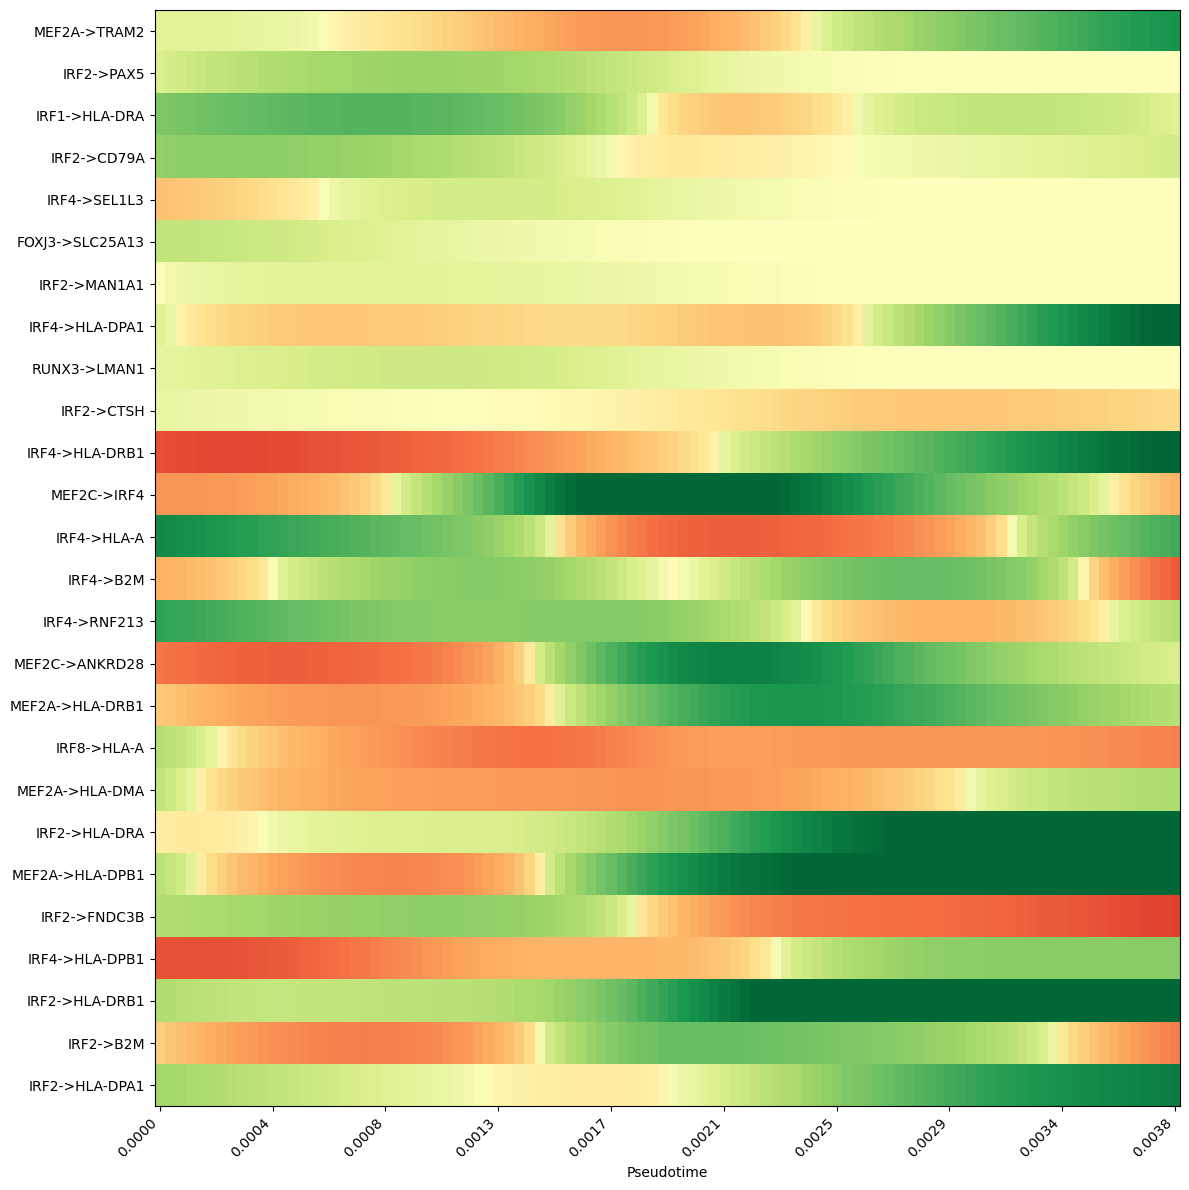

In [84]:
fig, ax, force_values = plot_force_heatmap(
    force_df=least_similar_forces_pb,
    dtime=dtime_pb,
    figsize=(12, 12),
    cmap='RdYlGn'
)